Data Set Taken From https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks

# Summary of Findings

### Where do Major Power Outages Tend to Occur
- California has the most Major Power outages with Texas and Michigan following
- RFC and WECC almost have double the number of major power outages as compared to any other region

### Where do Major Power Outages take the longest to get back up and running?
- ECAR region tend to have longer major outages compared to any of the other regions

### When do Major Power Outages Tend to Occur?
- Major power outages tend to occur in the summer months of June, July, and August
- Major power outages have incresingly become more common compared to the early 2000s

### ML Model
- Looking to predict if a major power outage will occur
- Features Used: Month, Postal Code, Climate Catgory, Anomaly Level, Total_Price
- Used a decision tree classifier
- Improved Model by .037 using Grid Search
- Received a accuracy score of .81 

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [53]:
#Read in the data with certain columns
cols = ['YEAR', 'MONTH', 'POSTAL.CODE', 'NERC.REGION', 'OUTAGE.START.DATE', 
        'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME',
       'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'CAUSE.CATEGORY', 
        'CLIMATE.CATEGORY', 'ANOMALY.LEVEL', 'TOTAL.PRICE']
outages = pd.read_excel('outage.xlsx', skiprows = 5, usecols = cols).drop(index=0).reset_index(
    drop = True)

# Question: Where and when do major power outages tend to occur?

### Cleaning and EDA

In [54]:
#Looking at the missingness of each column to clean
prop_missing = outages.isna().sum()/len(outages)
prop_missing

YEAR                       0.000000
MONTH                      0.005867
POSTAL.CODE                0.000000
NERC.REGION                0.000000
ANOMALY.LEVEL              0.005867
CLIMATE.CATEGORY           0.005867
OUTAGE.START.DATE          0.005867
OUTAGE.START.TIME          0.005867
OUTAGE.RESTORATION.DATE    0.037810
OUTAGE.RESTORATION.TIME    0.037810
CAUSE.CATEGORY             0.000000
OUTAGE.DURATION            0.037810
DEMAND.LOSS.MW             0.459583
CUSTOMERS.AFFECTED         0.288787
TOTAL.PRICE                0.014342
dtype: float64

#### Filling in NaN Values

In [55]:
#Does data imputation by sampling from the distribution
def replace_w_sample(df, column_name):
    nan_affected = df[column_name].isna().sum()
    replacement_values = pd.Series(df[column_name].dropna().sample(nan_affected))
    replacement_values.index = df.loc[df[column_name].isnull()].index
    filled = df.fillna({column_name:replacement_values.to_dict()})
    return filled

Imputes the nan values for CUSTOMERS.AFFECTED, OUTAGE.DURATION, DEMAND.LOSS.MW by sampling from each column and filling in the nan values

In [56]:
outages_filled = replace_w_sample(outages, 'CUSTOMERS.AFFECTED')
outages_duration = replace_w_sample(outages_filled, 'OUTAGE.DURATION')
outages_and_loss_filled = replace_w_sample(outages_duration, 'DEMAND.LOSS.MW')

#### Defining Major Outage or Not

In [57]:
df_outages = outages_and_loss_filled.copy()
#Adding a column that defines a row as a Major outage or not
#Major Outage defined as impacted at least 50,000 customers and unplanned load loss of at least 300MW
df_outages['Major'] = df_outages.apply(lambda x: True if x['CUSTOMERS.AFFECTED'] >=50_000
                                      or x['DEMAND.LOSS.MW'] >= 300 else False, axis=1)

#### Combining Date and Time

In [58]:
#Change to timestamp
df_outages['OUTAGE.START.DATE'] = pd.to_datetime(df_outages['OUTAGE.START.DATE'])
df_outages['OUTAGE.START.TIME'] = df_outages['OUTAGE.START.TIME'].apply(lambda x: pd.Timestamp(str(x)))
df_outages['OUTAGE.RESTORATION.DATE'] = pd.to_datetime(df_outages['OUTAGE.RESTORATION.DATE'])
df_outages['OUTAGE.RESTORATION.TIME'] = df_outages['OUTAGE.RESTORATION.TIME'].apply(
    lambda x: pd.Timestamp(str(x)))
#Combine the two columns
df_outages['Outage Start'] = df_outages.apply(lambda x: x['OUTAGE.START.DATE']
                                              .replace(hour = x['OUTAGE.START.TIME'].hour, 
                                                       minute = x['OUTAGE.START.TIME'].minute,
                                                      second = x['OUTAGE.START.TIME'].second), axis=1)
df_outages['Restoration'] = df_outages.apply(lambda x: x['OUTAGE.RESTORATION.DATE']
                                              .replace(hour = x['OUTAGE.RESTORATION.TIME'].hour, 
                                                       minute = x['OUTAGE.RESTORATION.TIME'].minute,
                                                      second = x['OUTAGE.RESTORATION.TIME'].second), 
                                             axis=1)
#Dropping the unneeded columns because we combined them
df_outages = df_outages.drop(['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 
                              'OUTAGE.RESTORATION.TIME'], axis=1)

#### Getting Only Major Outages

In [59]:
#Filtering the table to only keep major outages
major = df_outages.loc[df_outages['Major']==True]


#### Univariate Analysis

The ouput of this cell is looking at the average duration and demand loss for each NERC region. This relates to my question because we are looking at the location of the major outage and giving us a better idea of when a power outage would tend to occur by looking at the peak demand lost and how that demand is related to the duration of the outage.

In [60]:
agg_table = major.groupby('NERC.REGION')[['OUTAGE.DURATION', 'DEMAND.LOSS.MW']].agg(['mean','median'])
agg_table

OUTAGE.DURATION         DEMAND.LOSS.MW        
                       mean  median           mean  median
NERC.REGION                                               
ECAR            5601.696970  5700.0    1241.060606   303.0
FRCC            4300.956522  1080.0    1395.695652   424.0
FRCC, SERC       372.000000   372.0     900.000000   900.0
HECO            1224.500000  1224.5     640.000000   640.0
HI              1367.000000  1367.0    1060.000000  1060.0
MRO             3255.000000  1454.5     576.470588   336.5
NPCC            4469.841584  2108.0     933.663366   220.0
PR               174.000000   174.0     220.000000   220.0
RFC             3710.856269  2680.0     397.532110   240.0
SERC            2084.818750   972.5     743.881250   278.0
SPP             3692.240000  1296.0     909.520000   205.0
TRE             2963.808081  1110.0     669.393939   265.0
WECC            1654.398625   369.0     899.147766   280.0

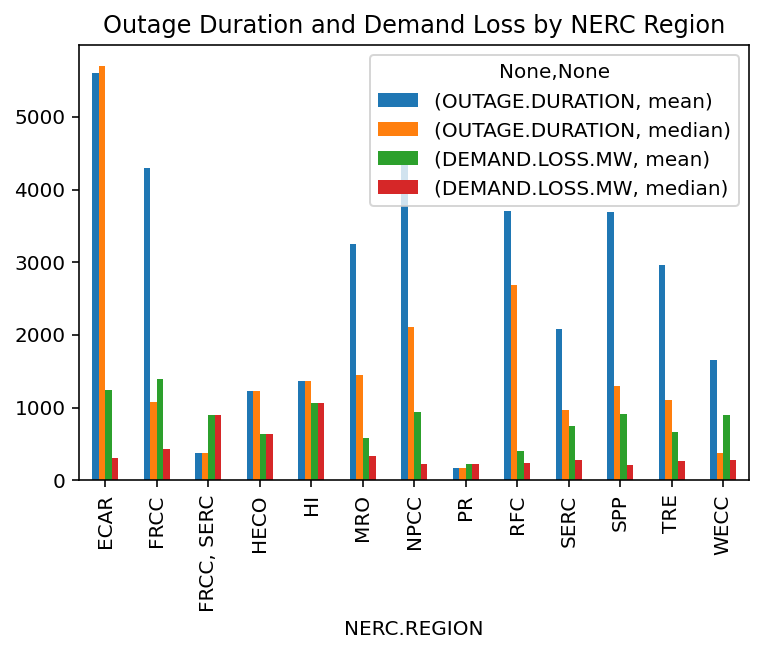

In [61]:
agg_table.plot(kind = 'bar', title = "Outage Duration and Demand Loss by NERC Region")
plt.show()

Looking at the mean and median  of outage duration and demand loss for each nerc region, we can see that ECAR has long usually has long outages because the mean and median are similar to each other. The other regions usually has a large mean duration because a couple of bad outages but the median is not as bad.

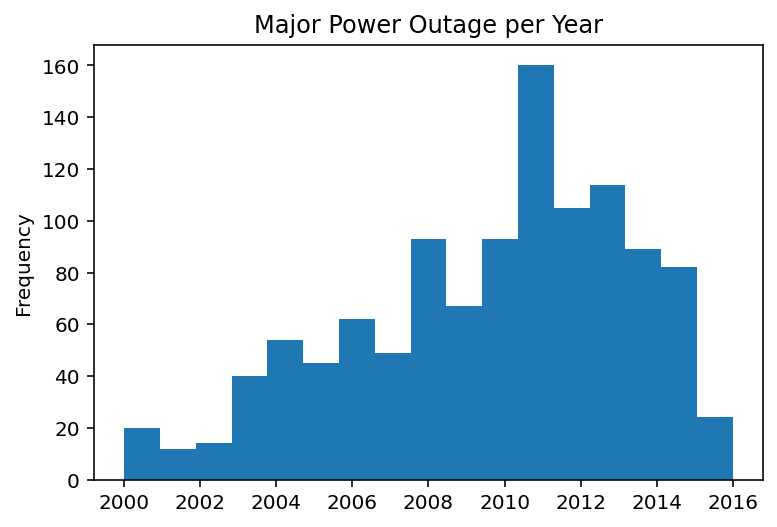

In [125]:
major['YEAR'].plot(kind='hist', bins = 2016-2000+1, title="Major Power Outage per Year")
plt.show()

From the histogram, we can see a left skew in the distribution where the outages are more common now than in the early 2000s. This is most likely due to the higher demand in electricity because of technological devices and also the electrical infastructure not improving.

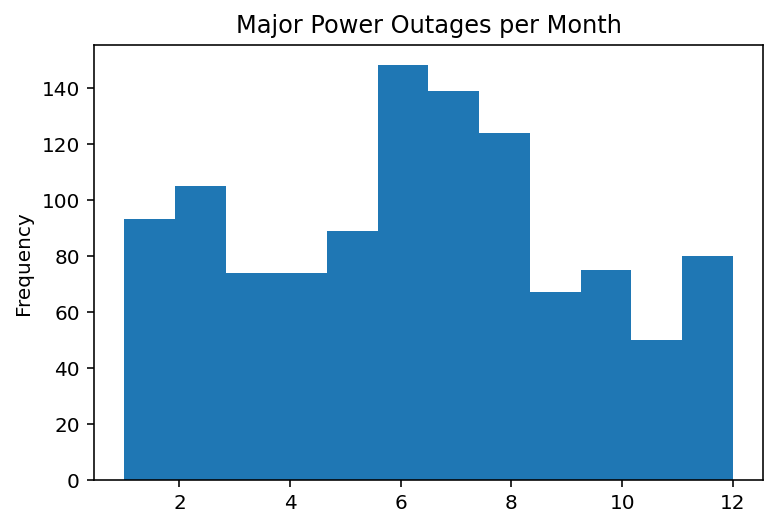

In [126]:
major['MONTH'].plot(kind='hist', bins=12, title="Major Power Outages per Month")
plt.show()

From the histogram, we can see that there is more outages in June, July, and August compared to any other month. This is most likely because the weather is hot during that period and also kids are home from school using more electricity,


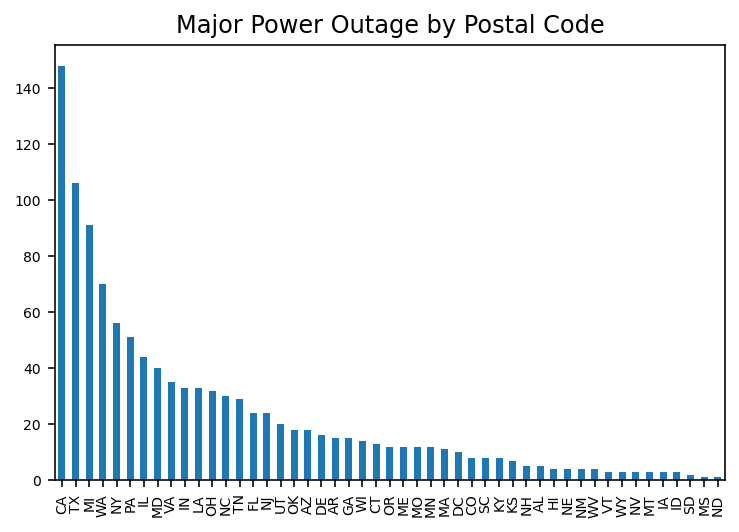

In [64]:
major['POSTAL.CODE'].value_counts().plot(kind='bar', fontsize=7, 
                                         title="Major Power Outage by Postal Code")
plt.show()

In this graph, we can see that the state with the most major power outages is California with Texas and Michigan following. California most likely has the most major power outages because the state has a lot of people per square mile which means more electricity is used in an area and more cars on the roads that may crash into electrical boxes.

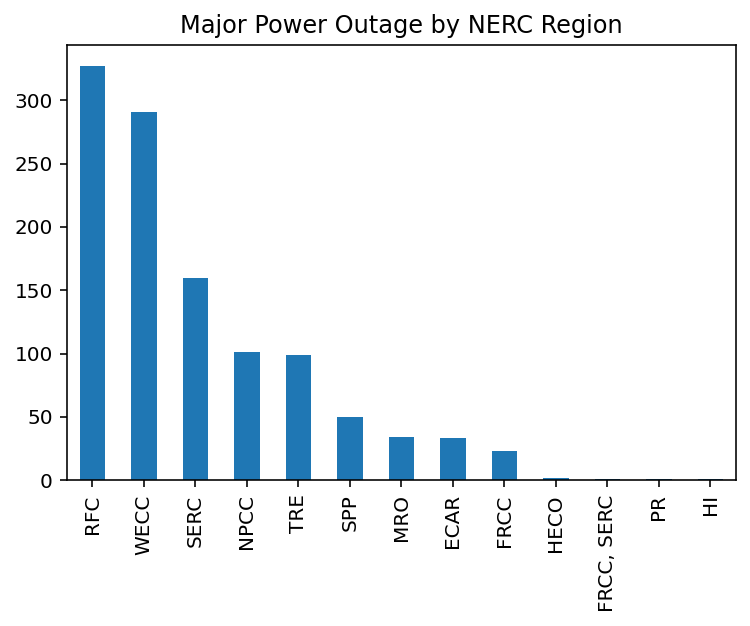

In [127]:
major['NERC.REGION'].value_counts().plot(kind='bar', title="Major Power Outage by NERC Region")
plt.show()

This piece of code produces a plot that shows us which NERC regions tend to have more major power outages than others. The regions that account for major power outages is RFC and WECC which are both almost double the number of major power outages compared to the other regions

#### Bivariate Analysis

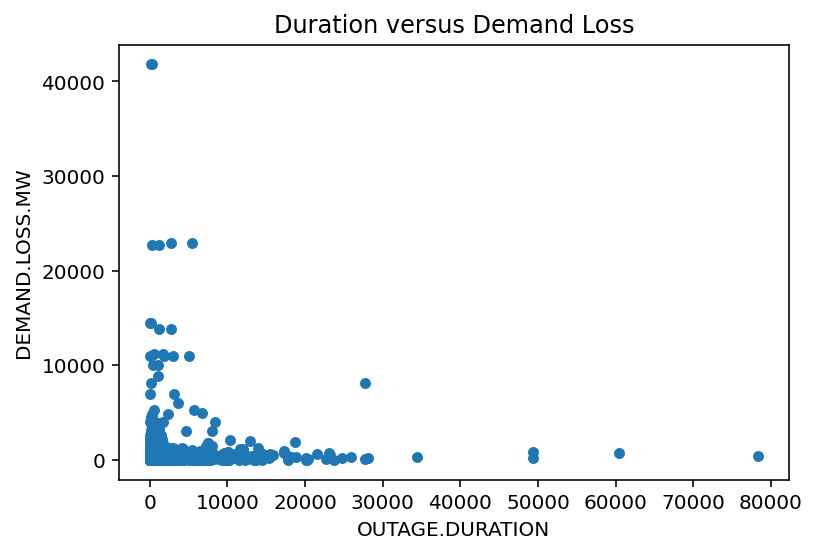

In [128]:
major.plot.scatter('OUTAGE.DURATION', 'DEMAND.LOSS.MW', title="Duration versus Demand Loss")
plt.show()

In the scatter plot, we are looking for an association between outage duration and demand loss. We can see that smaller outage durations tend to have a higher demand loss.


In [67]:
piv_table = major.pivot_table(
    values = "YEAR",
    index = "POSTAL.CODE",
    columns = "MONTH",
    aggfunc="count",
    fill_value = 0
    )
piv_table

MONTH,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
POSTAL.CODE,,,,,,,,,,,,
AL,0,0,0,0,0,1,1,1,0,0,0,1
AR,2,2,0,1,1,2,2,2,2,1,0,0
AZ,3,4,1,1,1,1,4,1,0,1,0,1
CA,11,18,13,8,16,10,17,8,7,15,8,17
CO,0,2,0,0,0,1,2,0,0,3,0,0
CT,1,0,2,1,2,1,1,1,1,1,2,0
DC,2,2,0,0,0,2,0,3,1,0,0,0
DE,0,0,1,2,3,3,1,2,0,0,3,0
FL,1,4,2,1,0,0,0,7,6,3,0,0


This pivot table counts the number of major power outages by postal code and month.


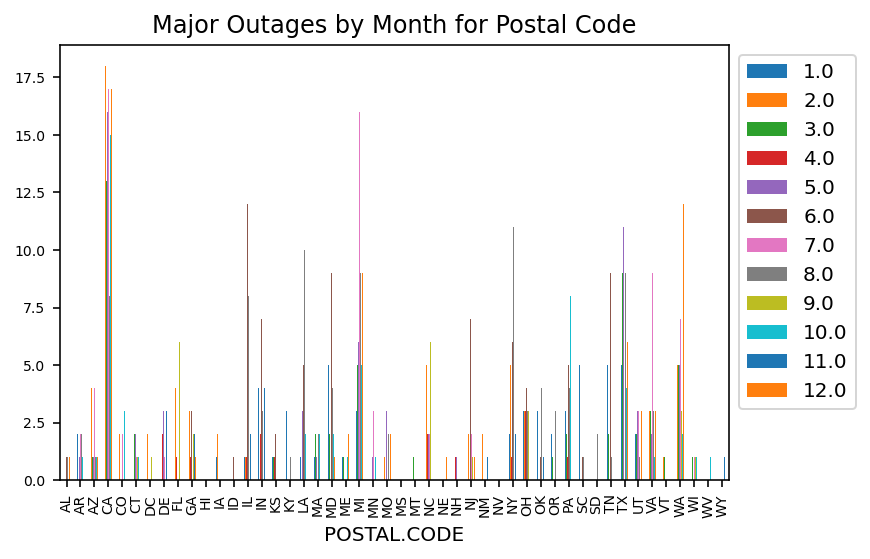

In [129]:
piv_table.plot(kind='bar', fontsize=7, title="Major Outages by Month for Postal Code")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

The plot shows 12 bars for each state. The bars show the number of power outages for each month. We are able to see which month each state tend to have their major power outages in.


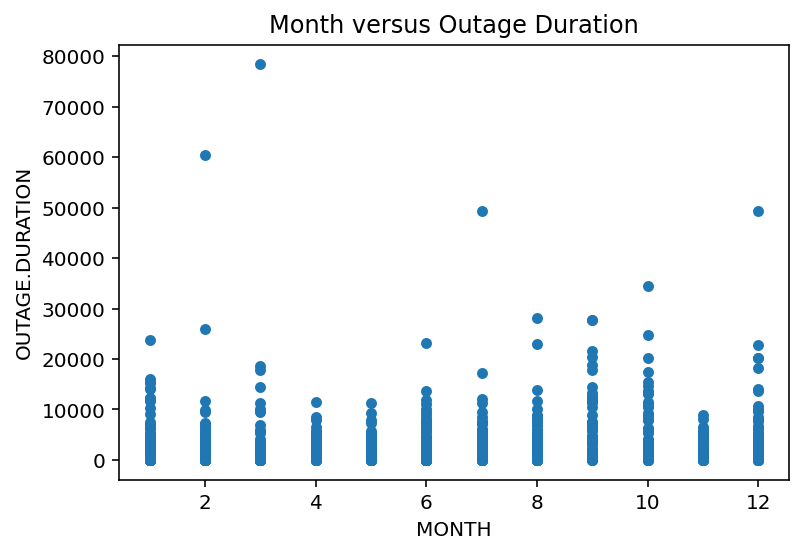

In [130]:
major.plot.scatter('MONTH', 'OUTAGE.DURATION', title="Month versus Outage Duration")
plt.show()

We are looking to see if there is an association between the month and duration of a major power outage. We would expect a major power outage to last longer in certain months over others because of different weather that may affect the work and electrical equipment. There does not seem to have a month where the outage durations tend to be a lot longer than the other months.

### Hypothesis Test

Null: The months June, July, August account for .35 of the major outages

Alternative: The months June, July, August account for less than .35 of the major outages

Test Statistic: Mean

Significance level: .05

P-value: .4742

Results: Since p-value >.05, we favor the null hypothesis that June, July, August account for .36 of the major outages

Justification: I chose to use mean as the test statistic because it allows us to find the proportion of the sample that happens in June, July, August. I chose a significance level of .05 because if 5/100 times we draw the wrong conclusion, then we should look at the results again.

In [131]:
observed_prop = len(major[major['MONTH'].isin([6,7,8])])/len(major)
observed_prop

0.3659839715048976

In [132]:
N = 5000
averages = []
data = major['MONTH'].dropna() #Drops all NaN values to sample from it
for i in np.arange(N):
    random_sample = (data.sample(len(data), replace=True)).isin([6,7,8])
    #Getting the sample and the proportion that are June, July, August
    averages.append(np.mean(random_sample))
averages = np.array(averages)

In [133]:
p_value = np.mean(averages<=observed_prop)
p_value

0.4742

## Supervised Learning: Predict if Customers will be Affected by Outages

### Baseline Model

In [183]:
cols_features = ['MONTH', 'POSTAL.CODE', 'CLIMATE.CATEGORY', 'ANOMALY.LEVEL',
       'CUSTOMERS.AFFECTED', 'TOTAL.PRICE']
ml_features = df_outages[cols_features]

In [184]:
ml_features.isna().sum()

MONTH                  9
POSTAL.CODE            0
CLIMATE.CATEGORY       9
ANOMALY.LEVEL          9
CUSTOMERS.AFFECTED     0
TOTAL.PRICE           22
dtype: int64

In [185]:
outages_filled = ml_features.dropna()

I chose to drop the null values because there were so little of them that would not affect the result by much

### Splitting the Dataset

In [197]:
#splits the dataset into the test and training
from sklearn.model_selection import train_test_split

X = outages_filled.drop('CUSTOMERS.AFFECTED', axis=1)
y = (outages_filled['CUSTOMERS.AFFECTED']!=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Predict if Customers will be Afffected by Outages

### Baseline Model

In [198]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.preprocessing as pp
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [199]:
categorical = ['POSTAL.CODE', 'CLIMATE.CATEGORY']
#Doing a One Hot Econding for all the nominval variables
prepoc = ColumnTransformer(
    transformers =[
        ('cat', pp.OneHotEncoder(handle_unknown='ignore'), categorical)
    ],
    remainder = 'passthrough')
#Pipeline that does the transformations on the columns we made and the Decision Tree Classifier
pl = Pipeline(steps=[('preprocessor', prepoc),
                   ('classifier', DecisionTreeClassifier())])

In [200]:
#Fitting the model
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['POSTAL.CODE',
                                                   'CLIMATE.CATEGORY'])])),
                ('classifier', DecisionTreeClassifier())])

In [201]:
#Getting the Accuracy Score
pl.score(X_test, y_test)

0.7724867724867724

### Final Model

In [204]:
categorical = ['POSTAL.CODE', 'CLIMATE.CATEGORY']
prepoc_ = ColumnTransformer(
    transformers =[
        #One hot encoding nominal variables
        ('cat_', pp.OneHotEncoder(handle_unknown='ignore'), categorical),
        #Standardizing the ANOMALY.LEVEL column
        ('std_scaling_', pp.StandardScaler(), ['ANOMALY.LEVEL']),
        #Binning the TOTAL.PRICE column
        ('bin', pp.KBinsDiscretizer(n_bins=6), ['TOTAL.PRICE'])
    ],
    remainder = 'passthrough')
#Pipeline that does the transformed column and the Decision Tree Classifier
pl_ = Pipeline(steps=[('preprocessor_', prepoc_),
                   ('classifier', DecisionTreeClassifier())])

In [205]:
#Fitting the model
pl_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['POSTAL.CODE',
                                                   'CLIMATE.CATEGORY']),
                                                 ('std_scaling_',
                                                  StandardScaler(),
                                                  ['ANOMALY.LEVEL']),
                                                 ('bin',
                                                  KBinsDiscretizer(n_bins=6),
                                                  ['TOTAL.PRICE'])])),
                ('classifier', DecisionTreeClassifier())])

In [206]:
#Getting the Accuracy Score
pl_.score(X_test, y_test)

0.7804232804232805

In [207]:
#The Max Depth of the Decision Tree Classifier
pl_.named_steps['classifier'].tree_.max_depth

36

In [208]:
#The number of node of the Decision Tree Classifier
pl_.named_steps['classifier'].tree_.node_count

561

In [209]:
#The parameters that we are going to test in the Grid Search
parameters = {
    'classifier__max_depth': [2,3,4,5,7,10,13,None], 
    'classifier__min_samples_split':[2,3,5,7,10,15,20],
    'classifier__min_samples_leaf':[2,3,5,7,10,15,20]
}

In [210]:
#Doing the Grid Search
clf = GridSearchCV(pl_, param_grid=parameters, cv = 3)

In [211]:
#Fitting the Grid Search with our training data
clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor_',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['POSTAL.CODE',
                                                                          'CLIMATE.CATEGORY']),
                                                                        ('std_scaling_',
                                                                         StandardScaler(),
                                                                         ['ANOMALY.LEVEL']),
                                                                        ('bin',
                                                                         KBinsDiscretizer(n_bins=6),
        

In [212]:
#The best parameters for our model
clf.best_params_

{'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 20}

In [213]:
#Pipeline that does the transformed column and the Decision Tree Classifier with optimized parameters
pl_optimized = Pipeline(steps=[('preprocessor_', prepoc_),
                   ('classifier', DecisionTreeClassifier(max_depth=4, 
                                                         min_samples_split=2, min_samples_leaf=20))])

In [214]:
#Fitting the model
pl_optimized.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['POSTAL.CODE',
                                                   'CLIMATE.CATEGORY']),
                                                 ('std_scaling_',
                                                  StandardScaler(),
                                                  ['ANOMALY.LEVEL']),
                                                 ('bin',
                                                  KBinsDiscretizer(n_bins=6),
                                                  ['TOTAL.PRICE'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=20))])

In [215]:
pl_optimized.score(X_test, y_test)

0.8095238095238095